In [1]:
import argparse
import copy
import gc
import glob
import math
import os
import random
from inspect import isfunction
from typing import List, Union

import matplotlib
import matplotlib.animation as animation
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import statsmodels.api as sm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.utils as save_image
from einops import rearrange
from functools import partial
from IPython.core.debugger import set_trace
from IPython.display import display, Image
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot
from PIL import Image
from scipy.optimize import fsolve, minimize
from scipy.spatial.distance import jensenshannon
from scipy.special import rel_entr, kl_div
from scipy.misc import derivative
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from torch import einsum
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torch.nn.modules.activation import ReLU
from torchmetrics.functional import kl_divergence
from tqdm import tqdm, tqdm_notebook
import itertools
import RNA
from polyleven import levenshtein
from scipy.stats import ks_2samp,kstest,ttest_ind, mannwhitneyu, norm
from cliffs_delta import cliffs_delta
import logomaker

import warnings
warnings.filterwarnings('ignore')

import vMay7_UTRLM_Predictor as utrlm
import vMay7_RNAFM_Predictor as rnafm
from collections import OrderedDict
from Bio import SeqIO
# Set up any necessary specific library configurations
matplotlib.use('Agg')  # For matplotlib to work in headless mode
sns.set(style="whitegrid")  # Setting the seaborn style
%matplotlib inline

import re

{'<cls>': 0, '<pad>': 1, '<eos>': 2, '<unk>': 3, 'A': 4, 'C': 5, 'G': 6, 'U': 7, 'R': 8, 'Y': 9, 'K': 10, 'M': 11, 'S': 12, 'W': 13, 'B': 14, 'D': 15, 'H': 16, 'V': 17, 'N': 18, '-': 19, '<null_1>': 20, '<null_2>': 21, '<null_3>': 22, '<null_4>': 23, '<mask>': 24}


In [2]:
# 定义过滤函数
def filter_sequence(seq):
    patterns = [
        r'A{8,}',  # 匹配8个或更多连续的A
        r'T{8,}',  # 匹配8个或更多连续的T
        r'C{8,}',  # 匹配8个或更多连续的C
        r'G{4,}'   # 匹配4个或更多连续的G
    ]
    # 如果任何一个模式匹配，返回False
    return not any(re.search(pattern, seq) for pattern in patterns)

def get_sequences_biopython(filepath):
    sequences = []
    with open(filepath, "r") as file:
        for record in SeqIO.parse(file, "fasta"):
            sequences.append(str(record.seq))
    return sequences

def filter_ireslm_res(filename):
    ireslm_res = pd.read_csv(f'./res/{filename}')
    print(f'Total Generated: n = {len(ireslm_res)}')
    ireslm_res = ireslm_res[ireslm_res.Prob_Mean > 0.5]
    print(f'- Predicted Prob_Mean > 0.5: n = {len(ireslm_res)}')
    ireslm_res = ireslm_res[ireslm_res['sequence'].apply(filter_sequence)]
    print(f'- After filter the repeated AGCT: n = {len(ireslm_res)}')
    ireslm_res = ireslm_res[ireslm_res.length >= 160][ireslm_res.Prob_Mean > 0.5]
    print(f'- Select 160bp-200bp: n = {len(ireslm_res)}')
    ireslm_res = ireslm_res[ireslm_res.Prob_Mean > 0.9]
    print(f'- Select Prob_Mean > 0.9: n = {len(ireslm_res)}')
    
    ireslm_res['GC'] = get_gc_content_many(ireslm_res.sequence)

    sss, mfes = [], []
    for s in tqdm(ireslm_res.sequence):
        ss, mfe = RNA.fold(s)
        sss.append(ss)
        mfes.append(mfe)
    ireslm_res['structure'] = sss
    ireslm_res['mfe'] = mfes

    return ireslm_res

def filtered_res_plot(ireslm_res):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    # 在不同的子图中绘制每个变量的直方图
    sns.histplot(ireslm_res['mfe'], ax=axes[0, 0], color='blue', kde=True)
    axes[0, 0].set_title('MFE Distribution')

    sns.histplot(ireslm_res['GC'], ax=axes[0, 1], color='green', kde=True)
    axes[0, 1].set_title('GC Content Distribution')

    sns.histplot(ireslm_res['length'], ax=axes[1, 0], color='red', kde=True)
    axes[1, 0].set_title('Length Distribution')

    sns.histplot(ireslm_res['Prob_Mean'], ax=axes[1, 1], color='purple', kde=True)
    axes[1, 1].set_title('Probability Mean Distribution')

    # 调整子图间距
    plt.tight_layout()

    # 显示图形
    plt.show()

Total Generated: n = 6076
- Predicted Prob_Mean > 0.5: n = 6041
- After filter the repeated AGCT: n = 4363
- Select 160bp-200bp: n = 1418
- Select Prob_Mean > 0.9: n = 1349


100%|███████████████████████████████████████| 1349/1349 [01:05<00:00, 20.65it/s]


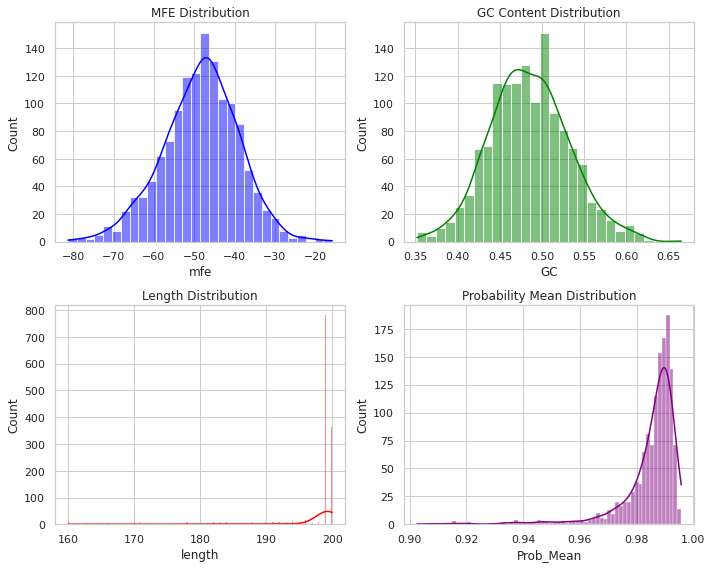

,sequence,length,Prob_Mean,Pred_Mean,Pred_U_Mean,Pred_R_Mean,Prob_U_Mean,Prob_R_Mean,Prob_U0,Prob_U1,...,Pred_R3,Pred_R4,Pred_R5,Pred_R6,Pred_R7,Pred_R8,Pred_R9,GC,structure,mfe
3544,TCATAGAATTGAGTTGCTGCCTACAAAATCTCAGACATTACCGAGG...,160,0.981152,1.0,1.0,1.0,0.989956,0.975870,0.990448,0.997361,...,1,1,1,1,1,1,1,0.51250,........((((..((((((......................((((...,-43.500000
3547,ATGCTGGCTTACCTCTGCGCACTGGCCCTTAGAATATTTACATTTA...,160,0.979244,1.0,1.0,1.0,0.991470,0.971908,0.992677,0.993281,...,1,1,1,1,1,1,1,0.46250,..(((.(((((((((((.(((..(((((..((.....(((((.......,-42.500000
3548,CCAGCTTCTCCATACAACCAGTGGAGAAGCGGCGACATTCACAACA...,160,0.975563,1.0,1.0,1.0,0.964884,0.981970,0.927011,0.960375,...,1,1,1,1,1,1,1,0.48750,((.((((((((((.......))))))))))))(((((((......)...,-39.400002
3549,ATCAAAACAATGCCGGCCCCTACGAGAGCAAACCCTACCGCGGTAA...,160,0.973077,1.0,1.0,1.0,0.987996,0.964126,0.992924,0.991052,...,1,1,1,1,1,1,1,0.48125,.(((((....((((((.......(((.(((...........((((....,-33.700001
3550,AAAAGCTGGCCGATTCACTACGCGGCAAATTATTTTTAATAGAAAA...,160,0.983360,1.0,1.0,1.0,0.991482,0.978487,0.994146,0.993429,...,1,1,1,1,1,1,1,0.42500,..............(((..((((((....(((((...))))).......,-26.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6068,TAAAACTCGGGTAGGCCAGGCAGTTGCGCGCCGTAGGCAGATAACC...,200,0.993490,1.0,1.0,1.0,0.996065,0.991945,0.996864,0.997045,...,1,1,1,1,1,1,1,0.49000,........(((((((((((((........)))....((.((........,-51.700001
6069,GTACCGGGTAGTCCACCTGCATGGGCCAGCACTCTCGTCCTAGACC...,200,0.990547,1.0,1.0,1.0,0.990935,0.990314,0.991985,0.992774,...,1,1,1,1,1,1,1,0.52500,....((((((((..(((((..((((((((((...(((............,-55.700001
6072,ATCAAACACCACCTCGTACCGTAATTAGCTCAACAAACACAATAGT...,200,0.985173,1.0,1.0,1.0,0.977754,0.989624,0.988298,0.986692,...,1,1,1,1,1,1,1,0.50000,.............(((((((((.....((((..((..(((....((...,-52.000000
6074,TTCTCAGGTAAGATCCGACATTGACAATACATGGGAATCTAAACCA...,200,0.965025,1.0,1.0,1.0,0.985787,0.952568,0.971890,0.987788,...,1,1,1,1,1,1,1,0.46000,(((((((((.((((((.................)).))))..)))....,-41.000000


In [6]:
filename = '../results/IRESDM_DirectedTraining_Gene_Class1_correctNum6076_ep149.csv'
ireslm_1410 = filter_ireslm_res(filename)
filtered_res_plot(ireslm_1410)
ireslm_1410.to_csv(f'FilterV1_{filename}')